# SMC vs VFE Phase Diagram

This notebook scans a small grid of **noise level** and **inducing count (M)**,
and compares SMC (Particle Feynman) vs VFE (Type-II) using the same FITC kernel family.

Outputs:
- Heatmaps of ΔNLPD and ΔRMSE (SMC − VFE).
- Lower values favor SMC.


In [1]:
import sys
from pathlib import Path
cwd = Path.cwd().resolve()
candidates = [cwd, *cwd.parents]
for p in candidates:
    if (p / 'infodynamics_jax').is_dir():
        sys.path.insert(0, str(p))
        sys.path.insert(0, str(p / 'examples'))
        break


In [2]:
import time
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from infodynamics_jax.core import Phi
from infodynamics_jax.gp.kernels import rbf
from infodynamics_jax.gp.kernels.params import KernelParams
from infodynamics_jax.gp.predict import predict_typeii
from infodynamics_jax.gp.sparsify import fitc_log_evidence, SparsifiedKernel
from infodynamics_jax.inference.optimisation import TypeII, TypeIICFG
from infodynamics_jax.energy import InertialEnergy, InertialCFG
from infodynamics_jax.inference.particle import AnnealedSMC, AnnealedSMCCFG
from infodynamics_jax.gp.likelihoods import get as get_likelihood
from infodynamics_jax.inference.optimisation.vfe import make_vfe_objective

from utils.synthetic_functions import synthetic
from utils.plotting_utils import compute_metrics
from utils.plotting_style import setup_plot_style, COLORS, create_custom_colormap
from utils.smc_array_only import annealed_smc_array

setup_plot_style()
jax.config.update('jax_enable_x64', True)


## Configuration
Adjust the grid sizes for speed vs resolution.


In [3]:
class PhaseCFG:
    # data
    func_name = 'sine_mix'
    domain = (-2.5, 2.5)
    n_train = 120
    n_test = 60

    # grid
    noise_grid = [0.05, 0.1, 0.2]
    M_grid = [10, 15, 20]

    # SMC
    n_particles = 48
    n_steps = 16
    ess_threshold = 0.6
    rejuvenation_steps = 2
    step_size = 0.02
    n_leapfrog = 6

    # VFE (Type-II)
    typeii_steps = 150
    typeii_lr = 1e-2

cfg = PhaseCFG()


## Helpers
SMC runs on a pure array state `theta = [log_ell, log_sf2, log_sn2, Z_flat]`.
Prediction and metrics use weighted mixture formulas and mixture NLPD.


In [4]:
def theta_to_phi(theta, Z_shape, jitter):
    log_ell, log_sf2, log_sn2 = theta[0], theta[1], theta[2]
    Z = theta[3:].reshape(Z_shape)
    return Phi(
        kernel_params=KernelParams(lengthscale=jnp.exp(log_ell), variance=jnp.exp(log_sf2)),
        Z=Z,
        likelihood_params={'noise_var': jnp.exp(log_sn2)},
        jitter=jitter,
    )

def mixture_nlpd(y, mu_LN, var_LN, logw):
    logw = logw - jax.scipy.special.logsumexp(logw)
    log_pdf = -0.5 * (jnp.log(2 * jnp.pi * var_LN) + (y[None, :] - mu_LN) ** 2 / var_LN)
    logp = jax.scipy.special.logsumexp(logw[:, None] + log_pdf, axis=0)
    return -jnp.mean(logp)

def smc_predict_mixture(particles, logw, X_train, Y_train, X_test, Z_shape, jitter, k_top=10):
    logw = logw - jax.scipy.special.logsumexp(logw)
    w = jnp.exp(logw)
    k = int(jnp.minimum(k_top, w.shape[0]))
    idx = jnp.argsort(w)[-k:]
    w_sub = w[idx] / jnp.sum(w[idx])

    mus = []
    vars_ = []
    for i in idx.tolist():
        phi_i = theta_to_phi(particles[int(i)], Z_shape, jitter)
        mu_i, var_i = predict_typeii(phi_i, X_test, X_train, Y_train, rbf, residual='fitc')
        mus.append(mu_i)
        vars_.append(var_i)

    mus = jnp.stack(mus)
    vars_ = jnp.maximum(jnp.stack(vars_), 1e-12)

    mean = (w_sub[:, None] * mus).sum(axis=0)
    second = (w_sub[:, None] * (vars_ + mus**2)).sum(axis=0)
    var = jnp.maximum(second - mean**2, 1e-12)

    nlpd = mixture_nlpd(Y_test, mus, vars_, logw[idx])
    return mean, var, nlpd


## Phase Scan
This loop runs SMC and VFE across (noise_std, M). Adjust grids for speed.


In [5]:
key = jax.random.key(0)
fn, title, _, _ = synthetic.get(cfg.func_name)

rmse_smc = np.zeros((len(cfg.noise_grid), len(cfg.M_grid)))
rmse_vfe = np.zeros_like(rmse_smc)
nlpd_smc = np.zeros_like(rmse_smc)
nlpd_vfe = np.zeros_like(rmse_smc)

for i, noise_std in enumerate(cfg.noise_grid):
    key, subkey = jax.random.split(key)
    X_all, Y_all, _ = synthetic.sample(
        cfg.func_name,
        N=cfg.n_train + cfg.n_test,
        noise=noise_std,
        domain=cfg.domain,
        key=subkey,
    )
    X_all = X_all[:, None]

    key, subkey = jax.random.split(key)
    perm = jax.random.permutation(subkey, X_all.shape[0])
    train_idx = perm[:cfg.n_train]
    test_idx = perm[cfg.n_train:]

    X_train = X_all[train_idx]
    Y_train = Y_all[train_idx]
    X_test = X_all[test_idx]
    Y_test = Y_all[test_idx]

    for j, M in enumerate(cfg.M_grid):
        key, subkey = jax.random.split(key)
        z_idx = jax.random.permutation(subkey, X_train.shape[0])[:M]
        Z0 = X_train[z_idx]

        phi_init = Phi(
            kernel_params=KernelParams(lengthscale=jnp.array(1.0), variance=jnp.array(1.0)),
            Z=Z0,
            likelihood_params={'noise_var': jnp.array(noise_std**2)},
            jitter=1e-6,
        )

        # --- VFE (Type-II) ---
        vfe_objective = make_vfe_objective(kernel_fn=rbf, residual='fitc')
        typeii_cfg = TypeIICFG(steps=cfg.typeii_steps, lr=cfg.typeii_lr, optimizer='adam', jit=True, constrain_params=True)
        typeii = TypeII(cfg=typeii_cfg)
        key, subkey = jax.random.split(key)
        out = typeii.run(energy=vfe_objective, phi_init=phi_init, energy_args=(X_train, Y_train))
        phi_vfe = out.phi

        vfe_mean, vfe_var = predict_typeii(phi_vfe, X_test, X_train, Y_train, rbf, residual='fitc')
        vfe_metrics = compute_metrics(Y_test, vfe_mean, jnp.sqrt(vfe_var))
        rmse_vfe[i, j] = vfe_metrics['rmse']
        nlpd_vfe[i, j] = vfe_metrics['nlpd']

        # --- SMC (array-only) ---
        def energy_theta(theta):
            log_ell, log_sf2, log_sn2 = theta[0], theta[1], theta[2]
            Z = theta[3:].reshape(Z0.shape)
            params = KernelParams(lengthscale=jnp.exp(log_ell), variance=jnp.exp(log_sf2))
            return -fitc_log_evidence(
                kernel_fn=rbf,
                params=params,
                X=X_train,
                y=Y_train,
                Z=Z,
                noise_var=jnp.exp(log_sn2),
                jitter=phi_init.jitter,
            )

        def init_particles_array(key, n_particles):
            key_l, key_v, key_n, key_z = jax.random.split(key, 4)
            log_ell = jnp.log(phi_init.kernel_params.lengthscale) + jax.random.normal(key_l, (n_particles,)) * 0.5
            log_sf2 = jnp.log(phi_init.kernel_params.variance) + jax.random.normal(key_v, (n_particles,)) * 0.5
            log_sn2 = jnp.log(phi_init.likelihood_params['noise_var']) + jax.random.normal(key_n, (n_particles,)) * 0.5
            Z_noisy = Z0[None, :, :] + 0.2 * jax.random.normal(key_z, (n_particles, *Z0.shape))
            return jnp.concatenate(
                [log_ell[:, None], log_sf2[:, None], log_sn2[:, None], Z_noisy.reshape(n_particles, -1)],
                axis=1,
            )

        key, subkey = jax.random.split(key)
        init_particles = init_particles_array(subkey, cfg.n_particles)
        smc_out = annealed_smc_array(
            key=subkey,
            init_particles=init_particles,
            energy_fn=energy_theta,
            n_steps=cfg.n_steps,
            ess_threshold=cfg.ess_threshold,
            step_size=cfg.step_size,
            n_leapfrog=cfg.n_leapfrog,
            rejuvenation_steps=cfg.rejuvenation_steps,
        )

        smc_mean, smc_var, smc_nlpd = smc_predict_mixture(
            smc_out['particles'], smc_out['logw'], X_train, Y_train, X_test, Z0.shape, phi_init.jitter, k_top=10
        )
        smc_metrics = compute_metrics(Y_test, smc_mean, jnp.sqrt(smc_var))
        rmse_smc[i, j] = smc_metrics['rmse']
        nlpd_smc[i, j] = float(smc_nlpd)

        print("noise={:.2f} M={:02d} | RMSE SMC/VFE: {:.3f}/{:.3f} | NLPD SMC/VFE: {:.3f}/{:.3f}"
              .format(noise_std, M, rmse_smc[i, j], rmse_vfe[i, j], nlpd_smc[i, j], nlpd_vfe[i, j]))


noise=0.05 M=10 | RMSE SMC/VFE: 0.069/0.228 | NLPD SMC/VFE: -1.434/-0.018
noise=0.05 M=15 | RMSE SMC/VFE: 0.048/0.223 | NLPD SMC/VFE: -1.639/-0.045
noise=0.05 M=20 | RMSE SMC/VFE: 0.047/0.229 | NLPD SMC/VFE: -1.598/-0.035
noise=0.10 M=10 | RMSE SMC/VFE: 0.106/0.301 | NLPD SMC/VFE: -0.812/0.156
noise=0.10 M=15 | RMSE SMC/VFE: 0.109/0.214 | NLPD SMC/VFE: -0.820/-0.055
noise=0.10 M=20 | RMSE SMC/VFE: 0.107/0.211 | NLPD SMC/VFE: -0.811/-0.068
noise=0.20 M=10 | RMSE SMC/VFE: 0.228/0.276 | NLPD SMC/VFE: -0.037/0.174
noise=0.20 M=15 | RMSE SMC/VFE: 0.231/0.275 | NLPD SMC/VFE: 0.026/0.167
noise=0.20 M=20 | RMSE SMC/VFE: 0.231/0.276 | NLPD SMC/VFE: 0.008/0.174


## Phase Diagrams
Δ = SMC − VFE. Negative is better for SMC.


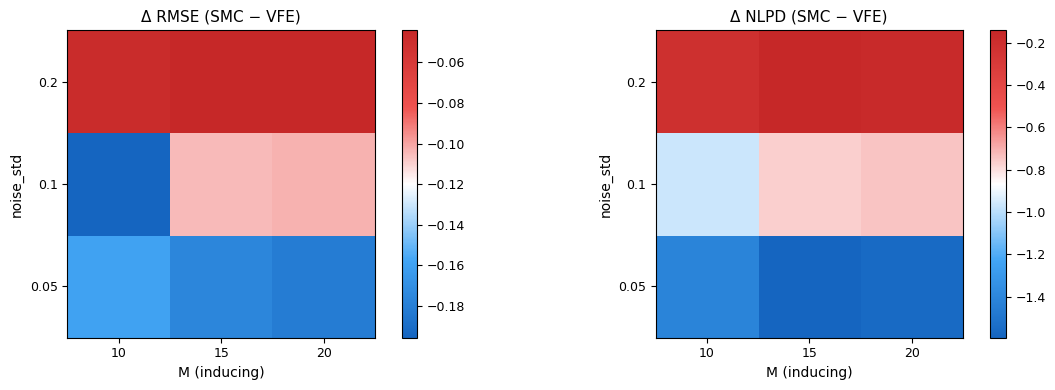

In [6]:
d_rmse = rmse_smc - rmse_vfe
d_nlpd = nlpd_smc - nlpd_vfe

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cmap = create_custom_colormap('diverging')
im0 = axes[0].imshow(d_rmse, cmap=cmap, origin='lower')
axes[0].set_title('Δ RMSE (SMC − VFE)')
axes[0].set_xlabel('M (inducing)')
axes[0].set_ylabel('noise_std')
axes[0].set_xticks(range(len(cfg.M_grid)))
axes[0].set_xticklabels(cfg.M_grid)
axes[0].set_yticks(range(len(cfg.noise_grid)))
axes[0].set_yticklabels(cfg.noise_grid)
fig.colorbar(im0, ax=axes[0], fraction=0.046)

im1 = axes[1].imshow(d_nlpd, cmap=cmap, origin='lower')
axes[1].set_title('Δ NLPD (SMC − VFE)')
axes[1].set_xlabel('M (inducing)')
axes[1].set_ylabel('noise_std')
axes[1].set_xticks(range(len(cfg.M_grid)))
axes[1].set_xticklabels(cfg.M_grid)
axes[1].set_yticks(range(len(cfg.noise_grid)))
axes[1].set_yticklabels(cfg.noise_grid)
fig.colorbar(im1, ax=axes[1], fraction=0.046)

plt.tight_layout()
plt.show()


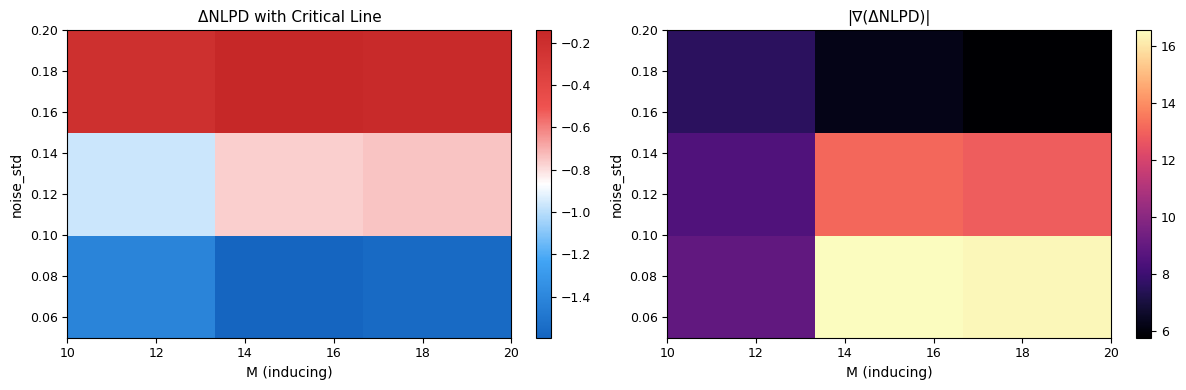

In [7]:
# Critical line (ΔNLPD = 0) + gradient magnitude
d_nlpd = nlpd_smc - nlpd_vfe

noise_vals = np.array(cfg.noise_grid)
M_vals = np.array(cfg.M_grid)
X, Y = np.meshgrid(M_vals, noise_vals)

# Gradient magnitude of ΔNLPD
grad_y, grad_x = np.gradient(d_nlpd, noise_vals, M_vals, edge_order=1)
grad_mag = np.sqrt(grad_x**2 + grad_y**2)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Panel 1: ΔNLPD with critical line
cmap = create_custom_colormap('diverging')
im0 = axes[0].imshow(d_nlpd, cmap=cmap, origin='lower',
                   extent=[M_vals.min(), M_vals.max(), noise_vals.min(), noise_vals.max()],
                   aspect='auto')
cs = axes[0].contour(X, Y, d_nlpd, levels=[0.0], colors='k', linewidths=2)
axes[0].clabel(cs, inline=True, fontsize=9, fmt='ΔNLPD=0')
axes[0].set_title('ΔNLPD with Critical Line')
axes[0].set_xlabel('M (inducing)')
axes[0].set_ylabel('noise_std')
fig.colorbar(im0, ax=axes[0], fraction=0.046)

# Panel 2: Gradient magnitude
im1 = axes[1].imshow(grad_mag, cmap='magma', origin='lower',
                   extent=[M_vals.min(), M_vals.max(), noise_vals.min(), noise_vals.max()],
                   aspect='auto')
axes[1].set_title('|∇(ΔNLPD)|')
axes[1].set_xlabel('M (inducing)')
axes[1].set_ylabel('noise_std')
fig.colorbar(im1, ax=axes[1], fraction=0.046)

plt.tight_layout()
plt.show()


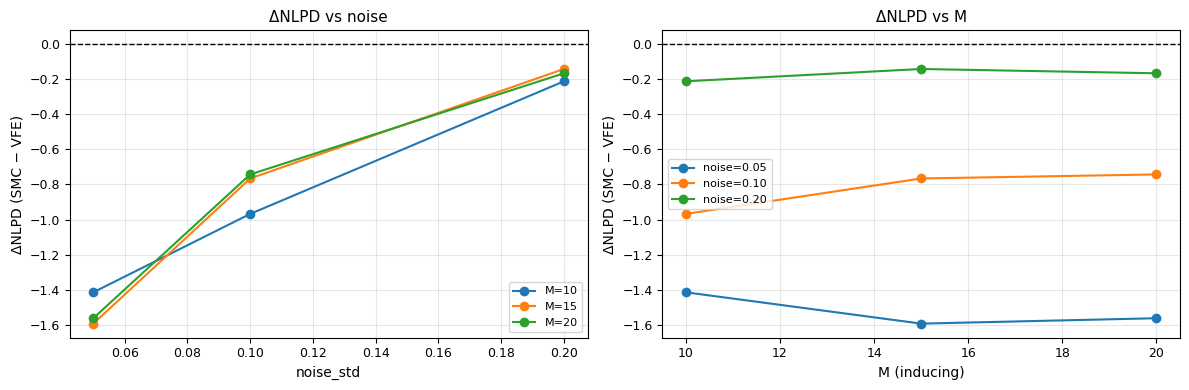

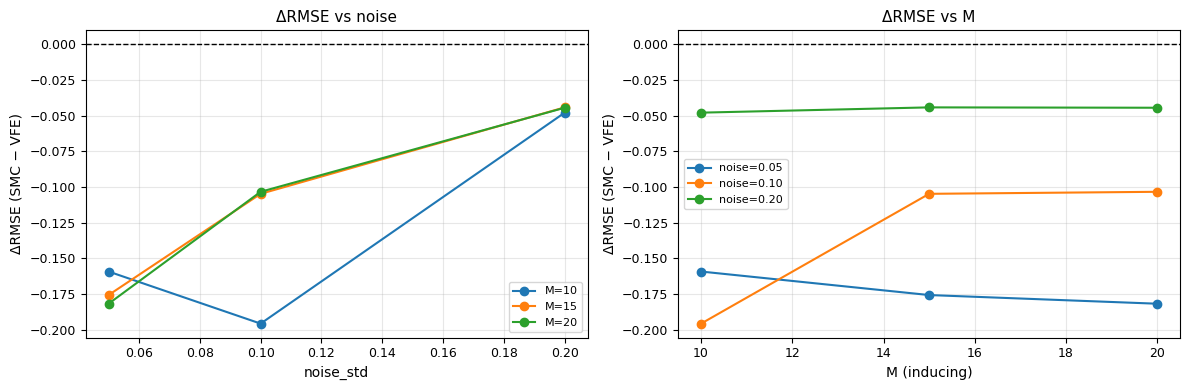

In [8]:
# Line plots for ΔNLPD and ΔRMSE (by M and by noise)
d_rmse = rmse_smc - rmse_vfe
d_nlpd = nlpd_smc - nlpd_vfe

noise_vals = np.array(cfg.noise_grid)
M_vals = np.array(cfg.M_grid)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ΔNLPD vs noise for each M
for j, M in enumerate(M_vals):
    axes[0].plot(noise_vals, d_nlpd[:, j], marker='o', label=f'M={M}')
axes[0].axhline(0.0, color='k', lw=1, ls='--')
axes[0].set_title('ΔNLPD vs noise')
axes[0].set_xlabel('noise_std')
axes[0].set_ylabel('ΔNLPD (SMC − VFE)')
axes[0].legend(fontsize=8)
axes[0].grid(alpha=0.3)

# ΔNLPD vs M for each noise
for i, noise in enumerate(noise_vals):
    axes[1].plot(M_vals, d_nlpd[i, :], marker='o', label=f'noise={noise:.2f}')
axes[1].axhline(0.0, color='k', lw=1, ls='--')
axes[1].set_title('ΔNLPD vs M')
axes[1].set_xlabel('M (inducing)')
axes[1].set_ylabel('ΔNLPD (SMC − VFE)')
axes[1].legend(fontsize=8)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ΔRMSE vs noise for each M
for j, M in enumerate(M_vals):
    axes[0].plot(noise_vals, d_rmse[:, j], marker='o', label=f'M={M}')
axes[0].axhline(0.0, color='k', lw=1, ls='--')
axes[0].set_title('ΔRMSE vs noise')
axes[0].set_xlabel('noise_std')
axes[0].set_ylabel('ΔRMSE (SMC − VFE)')
axes[0].legend(fontsize=8)
axes[0].grid(alpha=0.3)

# ΔRMSE vs M for each noise
for i, noise in enumerate(noise_vals):
    axes[1].plot(M_vals, d_rmse[i, :], marker='o', label=f'noise={noise:.2f}')
axes[1].axhline(0.0, color='k', lw=1, ls='--')
axes[1].set_title('ΔRMSE vs M')
axes[1].set_xlabel('M (inducing)')
axes[1].set_ylabel('ΔRMSE (SMC − VFE)')
axes[1].legend(fontsize=8)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


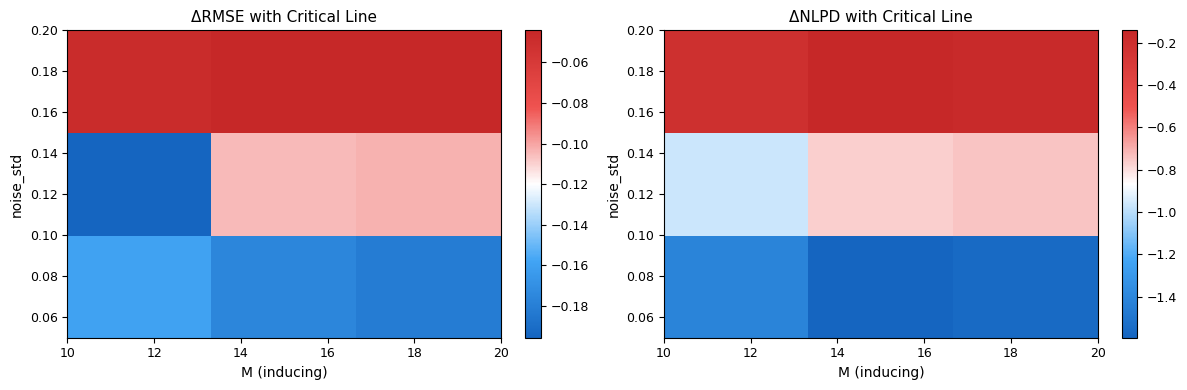

In [9]:
# Heatmap + contour overlay
d_rmse = rmse_smc - rmse_vfe
d_nlpd = nlpd_smc - nlpd_vfe

noise_vals = np.array(cfg.noise_grid)
M_vals = np.array(cfg.M_grid)
X, Y = np.meshgrid(M_vals, noise_vals)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cmap = create_custom_colormap('diverging')
im0 = axes[0].imshow(d_rmse, cmap=cmap, origin='lower',
                   extent=[M_vals.min(), M_vals.max(), noise_vals.min(), noise_vals.max()],
                   aspect='auto')
cs0 = axes[0].contour(X, Y, d_rmse, levels=[0.0], colors='k', linewidths=2)
axes[0].clabel(cs0, inline=True, fontsize=9, fmt='ΔRMSE=0')
axes[0].set_title('ΔRMSE with Critical Line')
axes[0].set_xlabel('M (inducing)')
axes[0].set_ylabel('noise_std')
fig.colorbar(im0, ax=axes[0], fraction=0.046)

im1 = axes[1].imshow(d_nlpd, cmap=cmap, origin='lower',
                   extent=[M_vals.min(), M_vals.max(), noise_vals.min(), noise_vals.max()],
                   aspect='auto')
cs1 = axes[1].contour(X, Y, d_nlpd, levels=[0.0], colors='k', linewidths=2)
axes[1].clabel(cs1, inline=True, fontsize=9, fmt='ΔNLPD=0')
axes[1].set_title('ΔNLPD with Critical Line')
axes[1].set_xlabel('M (inducing)')
axes[1].set_ylabel('noise_std')
fig.colorbar(im1, ax=axes[1], fraction=0.046)

plt.tight_layout()
plt.show()


In [10]:
# phase_diagram_pf.py
from __future__ import annotations

import argparse
import numpy as np
import jax
import jax.numpy as jnp

from infodynamics_jax.core.phi import Phi
from infodynamics_jax.gp.kernels import get as get_kernel
from infodynamics_jax.gp.sparsify import SparsifiedKernel
from infodynamics_jax.energy.inertial import InertialEnergy, InertialEnergyCFG
from infodynamics_jax.inference.particle import AnnealedSMC, AnnealedSMCCFG


# -------------------------
# small numeric helpers
# -------------------------
def logsumexp(x, axis=None):
    m = jnp.max(x, axis=axis, keepdims=True)
    return jnp.squeeze(m, axis=axis) + jnp.log(jnp.sum(jnp.exp(x - m), axis=axis))

def normalised_weights(logw):
    return jnp.exp(logw - logsumexp(logw))

def rmse(y, m):
    return float(jnp.sqrt(jnp.mean((y - m) ** 2)))

def nlpd_gaussian(y, m, s):
    v = jnp.maximum(s**2, 1e-12)
    return float(jnp.mean(0.5 * (jnp.log(2*jnp.pi*v) + (y - m)**2 / v)))

def coverage_2sigma(y, m, s):
    lo, hi = m - 2*s, m + 2*s
    return float(jnp.mean((y >= lo) & (y <= hi)) * 100.0)

def pairwise_mean_abs_distance_1d(z):
    z = jnp.sort(z)
    d = jnp.abs(z[:, None] - z[None, :])
    M = z.shape[0]
    tri = jnp.triu(d, k=1)
    denom = jnp.maximum(M * (M - 1) / 2.0, 1.0)
    return jnp.sum(tri) / denom

def z_order_params(particles, logw, x_min, x_max):
    # assumes Z shape (L, M, 1)
    w = normalised_weights(logw)
    z = particles.Z[..., 0]              # (L, M)
    z_std = jnp.std(z, axis=1)           # (L,)
    mpd = jax.vmap(pairwise_mean_abs_distance_1d)(z)  # (L,)
    scale = jnp.maximum(x_max - x_min, 1e-8)
    return {
        "z_std": float(jnp.sum(w * z_std)),
        "z_mpd": float(jnp.sum(w * mpd)),
        "z_std_norm": float(jnp.sum(w * (z_std / scale))),
        "z_mpd_norm": float(jnp.sum(w * (mpd / scale))),
    }


# -------------------------
# model pieces
# -------------------------
def make_energy(kernel_name="rbf", residual="fitc"):
    kernel_fn = get_kernel(kernel_name)
    sk = SparsifiedKernel(kernel_fn=kernel_fn, residual=residual)
    cfg = InertialEnergyCFG(kind="vfe_collapsed", residual=residual, kernel_name=kernel_name)
    return InertialEnergy(cfg=cfg, sparsified_kernel=sk), kernel_fn, sk

def bma_predict(particles, logw, X_tr, Y_tr, X_te, *, kernel_fn, sk, residual="fitc"):
    """
    BMA prediction across particles.
    NOTE: this is dense in N for each particle; keep N modest for phase sweeps.
    """
    w = normalised_weights(logw)
    y = Y_tr.reshape((-1, 1))
    N = y.shape[0]

    def pred_one(phi: Phi):
        Sff = sk.S_ff(phi.kernel_params, X_tr, phi.Z, jitter=phi.jitter)
        nv = jnp.asarray(phi.likelihood_params["noise_var"]).reshape(())
        K = Sff + nv * jnp.eye(N, dtype=Sff.dtype)

        L = jnp.linalg.cholesky(K)
        alpha = jax.scipy.linalg.cho_solve((L, True), y)  # (N,1)

        # Nyström cross-cov Q_*f
        K_xz = kernel_fn(phi.kernel_params, X_tr, phi.Z)        # (N,M)
        K_sz = kernel_fn(phi.kernel_params, X_te, phi.Z)        # (N*,M)
        K_zz = kernel_fn(phi.kernel_params, phi.Z, phi.Z)
        K_zz = 0.5 * (K_zz + K_zz.T) + phi.jitter * jnp.eye(K_zz.shape[0], dtype=K_zz.dtype)
        Lzz = jnp.linalg.cholesky(K_zz)
        A = jax.scipy.linalg.cho_solve((Lzz, True), K_xz.T)      # (M,N)
        Q_sf = K_sz @ A                                          # (N*,N)

        mean = (Q_sf @ alpha)[:, 0]

        # predictive variance (diagonal, FITC-style)
        B = jax.scipy.linalg.cho_solve((Lzz, True), K_sz.T)      # (M,N*)
        Q_ss = K_sz @ B                                          # (N*,N*)
        diagQss = jnp.diag(Q_ss)

        if residual.lower() == "fitc":
            Kss_diag = jnp.diag(kernel_fn(phi.kernel_params, X_te, X_te))
            rss = jnp.maximum(Kss_diag - diagQss, 0.0)
        else:
            rss = jnp.zeros_like(diagQss)

        v = jax.scipy.linalg.cho_solve((L, True), Q_sf.T)        # (N,N*)
        diag_term = jnp.sum(Q_sf * v.T, axis=1)
        var_lat = jnp.maximum(diagQss + rss - diag_term, 1e-12)
        std = jnp.sqrt(var_lat + nv)
        return mean, std

    means, stds = jax.vmap(pred_one)(particles)
    mean_mix = jnp.sum(w[:, None] * means, axis=0)
    second = jnp.sum(w[:, None] * (stds**2 + means**2), axis=0)
    var_mix = jnp.maximum(second - mean_mix**2, 1e-12)
    std_mix = jnp.sqrt(var_mix)
    return mean_mix, std_mix


# -------------------------
# one grid point run
# -------------------------
def run_point(
    key,
    X_tr, Y_tr, X_te, Y_te,
    *,
    phi_init: Phi,
    kernel_name="rbf",
    residual="fitc",
    n_particles=64,
    n_steps=24,
    beta_max=1.0,
    ess_threshold=0.5,
    rejuvenation_steps=3,
    step_size=0.02,
    n_leapfrog=6,
    init_Z_noise=0.2,
    x_min=-3.0,
    x_max=3.0,
):
    energy, kernel_fn, sk = make_energy(kernel_name, residual)

    smc_cfg = AnnealedSMCCFG(
        n_particles=n_particles,
        n_steps=n_steps,
        beta_max=beta_max,
        ess_threshold=ess_threshold,
        rejuvenation=True,
        rejuvenation_steps=rejuvenation_steps,
        step_size=step_size,
        n_leapfrog=n_leapfrog,
        jit=True,
    )
    smc = AnnealedSMC(cfg=smc_cfg)

    def init_particles_fn(k, L):
        k_l, k_v, k_n, k_z = jax.random.split(k, 4)
        lengthscale = jnp.exp(jax.random.normal(k_l, (L,)) * 0.5)
        variance = jnp.exp(jax.random.normal(k_v, (L,)) * 0.5)
        nv0 = jnp.asarray(phi_init.likelihood_params["noise_var"]).reshape(())
        noise_var = jnp.exp(jnp.log(nv0) + jax.random.normal(k_n, (L,)) * 0.5)
        Z = phi_init.Z[None, :, :] + init_Z_noise * jax.random.normal(k_z, (L, *phi_init.Z.shape))

        kp_type = type(phi_init.kernel_params)
        def pack(ls, var, nv, z):
            return Phi(
                kernel_params=kp_type(lengthscale=ls, variance=var),
                Z=z,
                likelihood_params={"noise_var": nv},
                jitter=phi_init.jitter,
            )
        return jax.vmap(pack)(lengthscale, variance, noise_var, Z)

    smc_res = smc.run(
        energy=energy,
        init_particles_fn=init_particles_fn,
        key=key,
        energy_args=(X_tr, Y_tr),
    )

    mean_te, std_te = bma_predict(
        smc_res.particles, smc_res.logw,
        X_tr, Y_tr, X_te,
        kernel_fn=kernel_fn,
        sk=sk,
        residual=residual,
    )

    out = {
        "logZ_est": float(smc_res.logZ_est),
        "ess_mean": float(jnp.mean(smc_res.ess_trace)),
        "ess_min": float(jnp.min(smc_res.ess_trace)),
        "rmse": rmse(Y_te, mean_te),
        "nlpd": nlpd_gaussian(Y_te, mean_te, std_te),
        "coverage": coverage_2sigma(Y_te, mean_te, std_te),
    }
    out.update(z_order_params(smc_res.particles, smc_res.logw, x_min, x_max))
    return out


def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--out", type=str, default="phase_pf.npz")
    ap.add_argument("--seed", type=int, default=0)
    args = ap.parse_args()

    key = jax.random.PRNGKey(args.seed)

    # dataset (replace with your loader if you prefer)
    def f(x):
        return jnp.sin(2.0 * x) + 0.3 * jnp.cos(5.0 * x)

    x_min, x_max = -3.0, 3.0
    N = 240
    noise_std = 0.2
    X_all = jnp.linspace(x_min, x_max, N).reshape((-1, 1))
    key, k_eps = jax.random.split(key)
    Y_all = f(X_all[:, 0]) + noise_std * jax.random.normal(k_eps, (N,))

    # train/test split
    key, k_perm = jax.random.split(key)
    perm = jax.random.permutation(k_perm, N)
    n_tr = int(0.8 * N)
    tr, te = perm[:n_tr], perm[n_tr:]
    X_tr, Y_tr = X_all[tr], Y_all[tr]
    X_te, Y_te = X_all[te], Y_all[te]

    # baseline Phi init
    from infodynamics_jax.gp.kernels import KernelParams
    M0 = 20
    key, k_z = jax.random.split(key)
    z_idx = jax.random.choice(k_z, n_tr, (M0,), replace=False)
    Z0 = X_tr[z_idx]

    phi_init = Phi(
        kernel_params=KernelParams(lengthscale=1.0, variance=1.0),
        Z=Z0,
        likelihood_params={"noise_var": noise_std**2},
        jitter=1e-6,
    )

    # sweep grid (start small)
    M_grid = [10, 20, 30, 40]
    beta_grid = [0.5, 1.0, 2.0]
    znoise_grid = [0.05, 0.2]

    n_particles = 64
    n_steps = 24

    rows = []
    meta = []
    for M in M_grid:
        key, k_z = jax.random.split(key)
        z_idx = jax.random.choice(k_z, n_tr, (M,), replace=False)
        phi_M = Phi(
            kernel_params=phi_init.kernel_params,
            Z=X_tr[z_idx],
            likelihood_params=phi_init.likelihood_params,
            jitter=phi_init.jitter,
        )

        for beta_max in beta_grid:
            for znoise in znoise_grid:
                key, k_run = jax.random.split(key)
                out = run_point(
                    k_run,
                    X_tr, Y_tr, X_te, Y_te,
                    phi_init=phi_M,
                    n_particles=n_particles,
                    n_steps=n_steps,
                    beta_max=beta_max,
                    init_Z_noise=znoise,
                    x_min=x_min,
                    x_max=x_max,
                )
                rows.append(out)
                meta.append((M, beta_max, znoise))
                print(f"[grid] M={M:02d} beta={beta_max:.2f} znoise={znoise:.2f} | "
                      f"logZ={out['logZ_est']:.2f} rmse={out['rmse']:.3f} nlpd={out['nlpd']:.3f} "
                      f"z_mpd_norm={out['z_mpd_norm']:.3f} ess_mean={out['ess_mean']:.1f}")

    keys = sorted(rows[0].keys())
    vals = np.array([[r[k] for k in keys] for r in rows], dtype=np.float64)
    meta = np.array(meta, dtype=np.float64)

    np.savez(args.out, keys=np.array(keys), values=vals,
             meta=meta, meta_cols=np.array(["M", "beta_max", "init_Z_noise"]))
    print("Saved:", args.out)


if __name__ == "__main__":
    main()

usage: ipykernel_launcher.py [-h] [--out OUT] [--seed SEED]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/cjrogerlo/Library/Jupyter/runtime/kernel-fed96815-c00b-4da7-9518-fc7d2b924ea8.json


SystemExit: 2

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/IPython/core/interactiveshell.py:3709: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## SMC Phase Sweep (M vs β_max)
This section mirrors the phase-diagram driver and records order parameters like Z collapse.


In [11]:
def logsumexp(x, axis=None):
    m = jnp.max(x, axis=axis, keepdims=True)
    return jnp.squeeze(m, axis=axis) + jnp.log(jnp.sum(jnp.exp(x - m), axis=axis))

def normalised_weights(logw):
    return jnp.exp(logw - logsumexp(logw))

def pairwise_mean_abs_distance_1d(z):
    z = jnp.sort(z)
    d = jnp.abs(z[:, None] - z[None, :])
    M = z.shape[0]
    tri = jnp.triu(d, k=1)
    denom = jnp.maximum(M * (M - 1) / 2.0, 1.0)
    return jnp.sum(tri) / denom

def z_order_params(particles, logw, x_min, x_max):
    w = normalised_weights(logw)
    z = particles.Z[..., 0]
    z_std = jnp.std(z, axis=1)
    mpd = jax.vmap(pairwise_mean_abs_distance_1d)(z)
    scale = jnp.maximum(x_max - x_min, 1e-8)
    return {
        'z_std': float(jnp.sum(w * z_std)),
        'z_mpd': float(jnp.sum(w * mpd)),
        'z_std_norm': float(jnp.sum(w * (z_std / scale))),
        'z_mpd_norm': float(jnp.sum(w * (mpd / scale))),
    }

def bma_predict(particles, logw, X_tr, Y_tr, X_te, *, kernel_fn, sk, residual='fitc'):
    w = normalised_weights(logw)
    y = Y_tr.reshape((-1, 1))
    N = y.shape[0]

    def pred_one(phi: Phi):
        Sff = sk.S_ff(phi.kernel_params, X_tr, phi.Z, jitter=phi.jitter)
        nv = jnp.asarray(phi.likelihood_params['noise_var']).reshape(())
        K = Sff + nv * jnp.eye(N, dtype=Sff.dtype)

        L = jnp.linalg.cholesky(K)
        alpha = jax.scipy.linalg.cho_solve((L, True), y)

        K_xz = kernel_fn(X_tr, phi.Z, phi.kernel_params)
        K_sz = kernel_fn(X_te, phi.Z, phi.kernel_params)
        K_zz = kernel_fn(phi.Z, phi.Z, phi.kernel_params)
        K_zz = 0.5 * (K_zz + K_zz.T) + phi.jitter * jnp.eye(K_zz.shape[0], dtype=K_zz.dtype)
        Lzz = jnp.linalg.cholesky(K_zz)
        A = jax.scipy.linalg.cho_solve((Lzz, True), K_xz.T)
        Q_sf = K_sz @ A

        mean = (Q_sf @ alpha)[:, 0]

        B = jax.scipy.linalg.cho_solve((Lzz, True), K_sz.T)
        Q_ss = K_sz @ B
        diagQss = jnp.diag(Q_ss)

        if residual.lower() == 'fitc':
            Kss_diag = jnp.diag(kernel_fn(X_te, X_te, phi.kernel_params))
            rss = jnp.maximum(Kss_diag - diagQss, 0.0)
        else:
            rss = jnp.zeros_like(diagQss)

        v = jax.scipy.linalg.cho_solve((L, True), Q_sf.T)
        diag_term = jnp.sum(Q_sf * v.T, axis=1)
        var_lat = jnp.maximum(diagQss + rss - diag_term, 1e-12)
        std = jnp.sqrt(var_lat + nv)
        return mean, std

    means, stds = jax.vmap(pred_one)(particles)
    mean_mix = jnp.sum(w[:, None] * means, axis=0)
    second = jnp.sum(w[:, None] * (stds**2 + means**2), axis=0)
    var_mix = jnp.maximum(second - mean_mix**2, 1e-12)
    std_mix = jnp.sqrt(var_mix)
    return mean_mix, std_mix


β=0.50 M=10 | logZ=-22.99 nlpd=0.062 z_mpd=0.300
β=0.50 M=20 | logZ=-8.11 nlpd=nan z_mpd=0.318
β=0.50 M=30 | logZ=-7.76 nlpd=-0.238 z_mpd=0.295
β=0.50 M=40 | logZ=-7.50 nlpd=nan z_mpd=0.319
β=1.00 M=10 | logZ=-18.25 nlpd=-0.143 z_mpd=0.340
β=1.00 M=20 | logZ=-13.25 nlpd=-0.247 z_mpd=0.292
β=1.00 M=30 | logZ=-13.87 nlpd=-0.204 z_mpd=0.308
β=1.00 M=40 | logZ=-13.26 nlpd=nan z_mpd=0.302
β=2.00 M=10 | logZ=-44.20 nlpd=-0.014 z_mpd=0.323
β=2.00 M=20 | logZ=-22.39 nlpd=-0.254 z_mpd=0.300
β=2.00 M=30 | logZ=-22.41 nlpd=-0.223 z_mpd=0.321
β=2.00 M=40 | logZ=-22.22 nlpd=-0.169 z_mpd=0.348


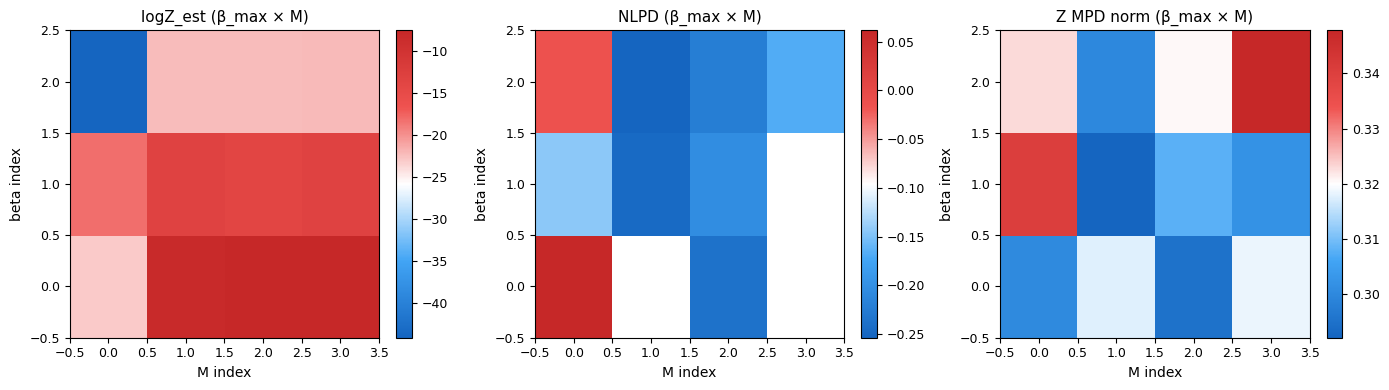

In [12]:
# Sweep grid for (M, beta_max)
kernel_fn = rbf
likelihood = get_likelihood('gaussian')

x_min, x_max = cfg.domain
X_plot = jnp.linspace(x_min, x_max, 240)[:, None]

M_grid = [10, 20, 30, 40]
beta_grid = [0.5, 1.0, 2.0]

grid_logZ = np.zeros((len(beta_grid), len(M_grid)))
grid_nlpd = np.zeros_like(grid_logZ)
grid_zmpd = np.zeros_like(grid_logZ)
grid_ess = np.zeros_like(grid_logZ)

key = jax.random.key(0)
fn, _, _, _ = synthetic.get(cfg.func_name)

key, subkey = jax.random.split(key)
X_all, Y_all, _ = synthetic.sample(cfg.func_name, N=cfg.n_train + cfg.n_test, noise=cfg.noise_grid[-1], domain=cfg.domain, key=subkey)
X_all = X_all[:, None]

key, subkey = jax.random.split(key)
perm = jax.random.permutation(subkey, X_all.shape[0])
train_idx = perm[:cfg.n_train]
test_idx = perm[cfg.n_train:]

X_train = X_all[train_idx]
Y_train = Y_all[train_idx]
X_test = X_all[test_idx]
Y_test = Y_all[test_idx]

for i, beta_max in enumerate(beta_grid):
    for j, M in enumerate(M_grid):
        key, subkey = jax.random.split(key)
        z_idx = jax.random.permutation(subkey, X_train.shape[0])[:M]
        Z0 = X_train[z_idx]

        phi_init = Phi(
            kernel_params=KernelParams(lengthscale=jnp.array(1.0), variance=jnp.array(1.0)),
            Z=Z0,
            likelihood_params={'noise_var': jnp.array(cfg.noise_grid[-1]**2)},
            jitter=1e-6,
        )

        sk = SparsifiedKernel(kernel_fn=kernel_fn, residual='fitc')
        cfg_energy = InertialCFG(estimator='analytic', analytic_mode='fitc_marginal')
        energy = InertialEnergy(kernel_fn=kernel_fn, likelihood=likelihood, cfg=cfg_energy, residual='fitc')

        betas = jnp.linspace(0.0, beta_max, cfg.n_steps + 1)
        smc_cfg = AnnealedSMCCFG(
            n_particles=cfg.n_particles,
            n_steps=cfg.n_steps,
            betas=betas,
            ess_threshold=cfg.ess_threshold,
            rejuvenation='hmc',
            rejuvenation_steps=cfg.rejuvenation_steps,
            step_size=cfg.step_size,
            n_leapfrog=cfg.n_leapfrog,
            jit=True,
        )
        smc = AnnealedSMC(cfg=smc_cfg)

        def init_particles_fn(k, L):
            k_l, k_v, k_n, k_z = jax.random.split(k, 4)
            lengthscale = jnp.exp(jax.random.normal(k_l, (L,)) * 0.5)
            variance = jnp.exp(jax.random.normal(k_v, (L,)) * 0.5)
            nv0 = jnp.asarray(phi_init.likelihood_params['noise_var']).reshape(())
            noise_var = jnp.exp(jnp.log(nv0) + jax.random.normal(k_n, (L,)) * 0.5)
            Z = phi_init.Z[None, :, :] + 0.2 * jax.random.normal(k_z, (L, *phi_init.Z.shape))
            kp_type = type(phi_init.kernel_params)
            def pack(ls, var, nv, z):
                return Phi(
                    kernel_params=kp_type(lengthscale=ls, variance=var),
                    Z=z,
                    likelihood_params={'noise_var': nv},
                    jitter=phi_init.jitter,
                )
            return jax.vmap(pack)(lengthscale, variance, noise_var, Z)

        key, subkey = jax.random.split(key)
        smc_res = smc.run(energy=energy, init_particles_fn=init_particles_fn, key=subkey, energy_args=(X_train, Y_train))

        mean_te, std_te = bma_predict(smc_res.particles, smc_res.logw, X_train, Y_train, X_test, kernel_fn=kernel_fn, sk=sk)
        grid_nlpd[i, j] = float(jnp.mean(0.5 * (jnp.log(2*jnp.pi*std_te**2) + (Y_test - mean_te)**2 / (std_te**2 + 1e-12))))
        grid_logZ[i, j] = float(smc_res.logZ_est)
        grid_ess[i, j] = float(jnp.mean(smc_res.ess_trace))
        grid_zmpd[i, j] = z_order_params(smc_res.particles, smc_res.logw, x_min, x_max)['z_mpd_norm']

        print(f'β={beta_max:.2f} M={M:02d} | logZ={grid_logZ[i,j]:.2f} nlpd={grid_nlpd[i,j]:.3f} z_mpd={grid_zmpd[i,j]:.3f}')

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
cmap = create_custom_colormap('diverging')

im0 = axes[0].imshow(grid_logZ, origin='lower', cmap=cmap, aspect='auto')
axes[0].set_title('logZ_est (β_max × M)')
axes[0].set_xlabel('M index')
axes[0].set_ylabel('beta index')
fig.colorbar(im0, ax=axes[0], fraction=0.046)

im1 = axes[1].imshow(grid_nlpd, origin='lower', cmap=cmap, aspect='auto')
axes[1].set_title('NLPD (β_max × M)')
axes[1].set_xlabel('M index')
axes[1].set_ylabel('beta index')
fig.colorbar(im1, ax=axes[1], fraction=0.046)

im2 = axes[2].imshow(grid_zmpd, origin='lower', cmap=cmap, aspect='auto')
axes[2].set_title('Z MPD norm (β_max × M)')
axes[2].set_xlabel('M index')
axes[2].set_ylabel('beta index')
fig.colorbar(im2, ax=axes[2], fraction=0.046)

plt.tight_layout()
plt.show()
